# Import session

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import imgaug.augmenters as iaa
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import tqdm
import tqdm.notebook as tqdm
from torch.nn.utils import clip_grad_norm_
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import textwrap
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, classification_report


tensor([1.], device='mps:0')


In [2]:
alleg_df = pd.read_csv('./data/SentenceTransformer_train.csv')
columns_to_drop = ['target', 'class_id']
alleg_df = alleg_df.drop(columns_to_drop, axis=1)
alleg_df.head()

path class_name  \
0  ../archive/images/apple_pie/1005649.jpg  apple_pie   
1  ../archive/images/apple_pie/1014775.jpg  apple_pie   
2  ../archive/images/apple_pie/1026328.jpg  apple_pie   
3  ../archive/images/apple_pie/1028787.jpg  apple_pie   
4  ../archive/images/apple_pie/1043283.jpg  apple_pie   

                                         ingredients  \
0  ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
1  ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
2  ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
3  ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
4  ['butter', 'flour', 'sugar', 'brown sugar', 'a...   

                                           allergies  Nut Allergy  \
0  ['Milk allergy / Lactose intolerance', 'Sugar ...            0   
1  ['Milk allergy / Lactose intolerance', 'Sugar ...            0   
2  ['Milk allergy / Lactose intolerance', 'Sugar ...            0   
3  ['Milk allergy / Lactose intolerance', 'Sugar ...            0   
4  ['Milk allergy / Lactose intolerance', 'Sugar ...            0   

   Oral Allergy Syndrome  Stone Fruit Allergy  Allium Allergy  \
0                      1                    0               0   
1                      1                    0               0   
2                      1                    0               0   
3                      1                    0               0   
4                      1                    0               0   

   Histamine Allergy  Legume Allergy  ...  Nightshade Allergy  \
0                  0               0  ...                   0   
1                  0               0  ...                   0   
2                  0               0  ...                   0   
3                  0               0  ...                   0   
4                  0               0  ...                   0   

   Sugar Allergy / Intolerance  LTP Allergy  Citrus Allergy  Honey Allergy  \
0                            1            0               0              0   
1                            1            0               0              0   
2                            1            0               0              0   
3                            1            0               0              0   
4                            1            0               0              0   

   Potato Allergy  Lactose Intolerance  Mint Allergy  Rice Allergy  \
0               0                    1             0             0   
1               0                    1             0             0   
2               0                    1             0             0   
3               0                    1             0             0   
4               0                    1             0             0   

   Soy Allergy  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 27 columns]

# Oversampling

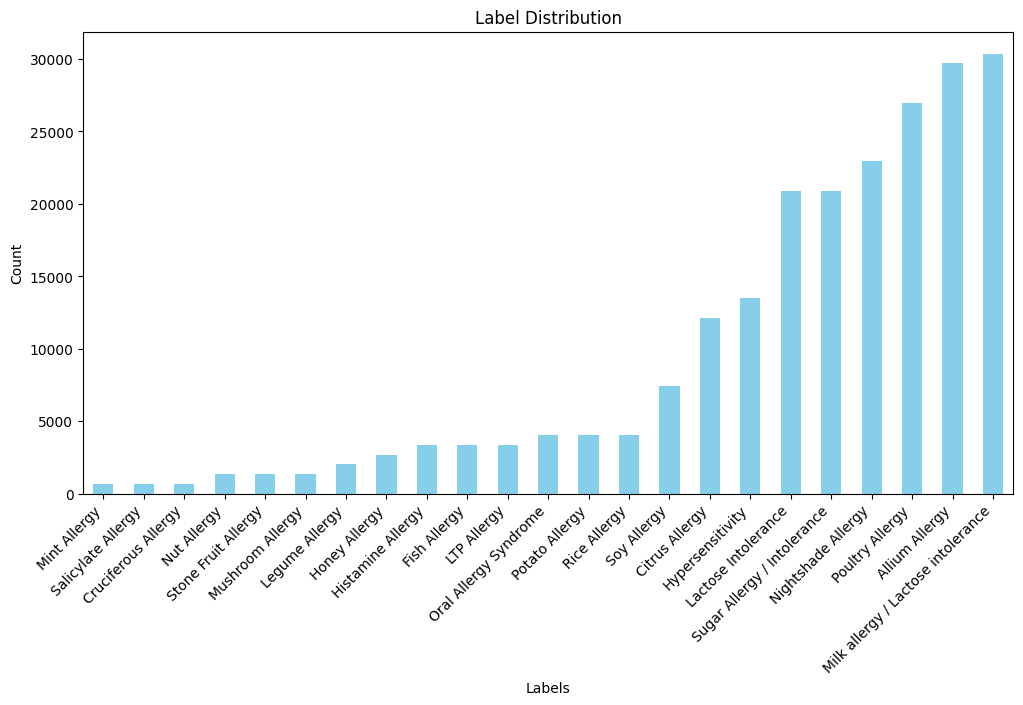

Mint Allergy                            675
Salicylate Allergy                      675
Cruciferous Allergy                     675
Nut Allergy                            1350
Stone Fruit Allergy                    1350
Mushroom Allergy                       1350
Legume Allergy                         2025
Honey Allergy                          2700
Histamine Allergy                      3375
Fish Allergy                           3375
LTP Allergy                            3375
Oral Allergy Syndrome                  4050
Potato Allergy                         4050
Rice Allergy                           4050
Soy Allergy                            7425
Citrus Allergy                        12150
Hypersensitivity                      13500
Lactose Intolerance                   20925
Sugar Allergy / Intolerance           20925
Nightshade Allergy                    22950
Poultry Allergy                       27000
Allium Allergy                        29700
Milk allergy / Lactose intoleran

In [7]:
column_sums = alleg_df[alleg_df.columns[4:]].sum()
sorted_columns = column_sums.sort_values(ascending=True).index
alleg_df = alleg_df[alleg_df.columns[:4].tolist() + sorted_columns.tolist()]

allergies = alleg_df.columns[4:]
label_counts = alleg_df[allergies].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
print(label_counts)

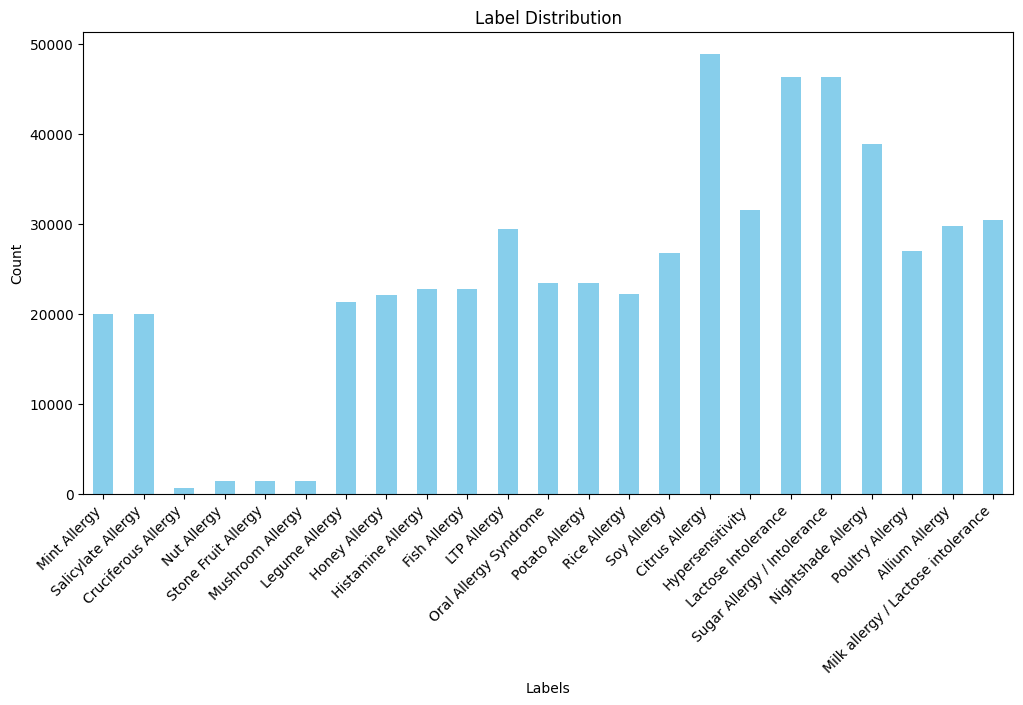

Mint Allergy                          20000
Salicylate Allergy                    20000
Cruciferous Allergy                     675
Nut Allergy                            1350
Stone Fruit Allergy                    1350
Mushroom Allergy                       1350
Legume Allergy                        21350
Honey Allergy                         22025
Histamine Allergy                     22700
Fish Allergy                          22700
LTP Allergy                           29463
Oral Allergy Syndrome                 23375
Potato Allergy                        23384
Rice Allergy                          22147
Soy Allergy                           26762
Citrus Allergy                        48896
Hypersensitivity                      31485
Lactose Intolerance                   46248
Sugar Allergy / Intolerance           46248
Nightshade Allergy                    38900
Poultry Allergy                       27000
Allium Allergy                        29700
Milk allergy / Lactose intoleran

In [8]:
keep_df = alleg_df[alleg_df['Milk allergy / Lactose intolerance'] == 1]
keep_df = alleg_df[(alleg_df[alleg_df.columns[-3:]] == 1).any(axis=1)]
upsample_df = alleg_df[(alleg_df[alleg_df.columns[-3:]] == 0).all(axis=1)]
threshold = 20000
label_columns = upsample_df.columns[4:]

for col in label_columns:
    minority_class = upsample_df[col] == 1
    minority_samples = upsample_df[minority_class]
    majority_samples = upsample_df[~minority_class]

    if not minority_samples.empty and len(minority_samples) < threshold:
        resampled_minority = minority_samples.sample(n=threshold, replace=True, random_state=42)
        upsample_df = pd.concat([majority_samples, resampled_minority])

train_df = pd.concat([upsample_df, keep_df])
labels = train_df.columns[4:]
label_counts = train_df[labels].sum()

plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

print(label_counts)
print(label_counts.max())


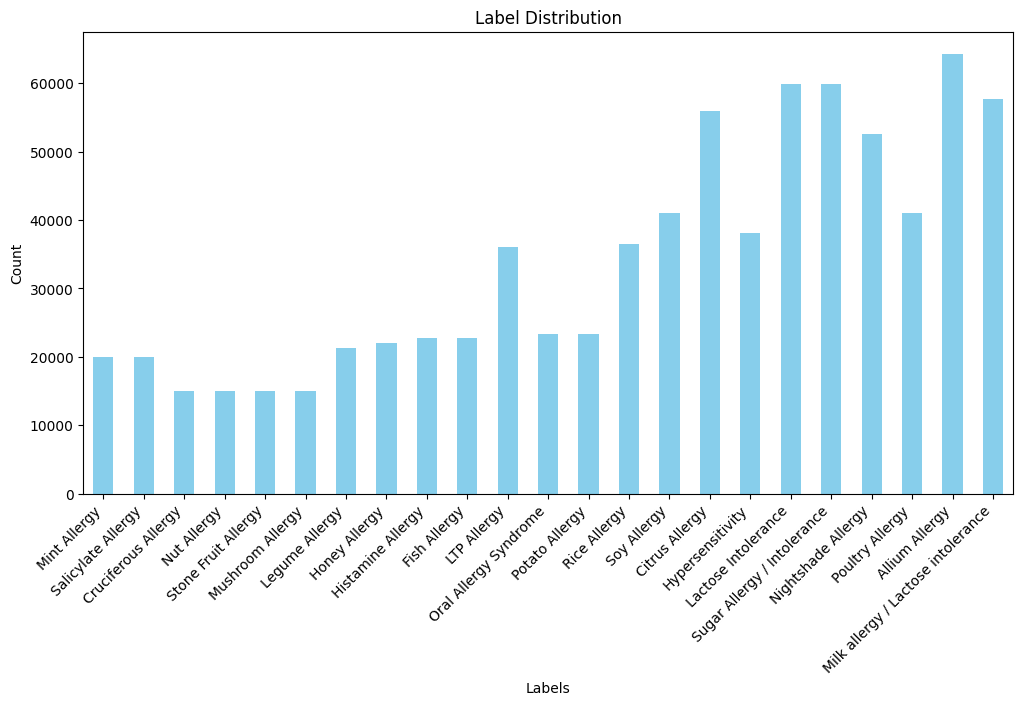

Mint Allergy                          20000
Salicylate Allergy                    20000
Cruciferous Allergy                   15000
Nut Allergy                           15000
Stone Fruit Allergy                   15000
Mushroom Allergy                      15000
Legume Allergy                        21350
Honey Allergy                         22025
Histamine Allergy                     22700
Fish Allergy                          22700
LTP Allergy                           36103
Oral Allergy Syndrome                 23375
Potato Allergy                        23384
Rice Allergy                          36472
Soy Allergy                           41087
Citrus Allergy                        55906
Hypersensitivity                      38125
Lactose Intolerance                   59898
Sugar Allergy / Intolerance           59898
Nightshade Allergy                    52550
Poultry Allergy                       41020
Allium Allergy                        64315
Milk allergy / Lactose intoleran

In [9]:
missing = []
threshold = 15000

# Identify labels with counts below the threshold
for label in train_df.columns[4:]:
    if label_counts[label] < threshold:
        missing.append(label)

# Function to oversample missing labels
def missing_label(column):
    index = train_df.columns.get_loc(column)
    keep_df = train_df[(train_df[column] == 0)]
    fraud_df = train_df[(train_df[column] == 1)]
    selected_columns = train_df.columns[index:-3]
    missing_df = fraud_df[(fraud_df[selected_columns] == 0).any(axis=1)]

    upsampled = []
    selected_columns = train_df.columns[index:-3]
    for k in selected_columns:
        df = missing_df[missing_df[k] == 1]
        if not df.empty:
            fraud_upsampled = df.sample(n=threshold, replace=True, random_state=42)
            upsampled.append(fraud_upsampled)
            missing_df = missing_df[missing_df[k] == 0]
    
    return pd.concat([keep_df] + upsampled)

# Oversample missing labels
for column in missing:
    train_df = missing_label(column)

# Visualize label distribution
labels = train_df.columns[4:]
label_counts = train_df[labels].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

print(label_counts)
print(label_counts.max())

# Prepare dataframe

In [10]:
val_df = pd.read_csv('./data/SentenceTransformer_val.csv')
test_df = pd.read_csv('./data/SentenceTransformer_test.csv')

In [11]:
all_columns = train_df.columns
val_df = val_df.reindex(columns=all_columns)
test_df = test_df.reindex(columns=all_columns)

In [12]:
train_df.columns

Index(['path', 'class_name', 'ingredients', 'allergies', 'Mint Allergy',
       'Salicylate Allergy', 'Cruciferous Allergy', 'Nut Allergy',
       'Stone Fruit Allergy', 'Mushroom Allergy', 'Legume Allergy',
       'Honey Allergy', 'Histamine Allergy', 'Fish Allergy', 'LTP Allergy',
       'Oral Allergy Syndrome', 'Potato Allergy', 'Rice Allergy',
       'Soy Allergy', 'Citrus Allergy', 'Hypersensitivity',
       'Lactose Intolerance', 'Sugar Allergy / Intolerance',
       'Nightshade Allergy', 'Poultry Allergy', 'Allium Allergy',
       'Milk allergy / Lactose intolerance'],
      dtype='object')

In [13]:
val_df.columns

Index(['path', 'class_name', 'ingredients', 'allergies', 'Mint Allergy',
       'Salicylate Allergy', 'Cruciferous Allergy', 'Nut Allergy',
       'Stone Fruit Allergy', 'Mushroom Allergy', 'Legume Allergy',
       'Honey Allergy', 'Histamine Allergy', 'Fish Allergy', 'LTP Allergy',
       'Oral Allergy Syndrome', 'Potato Allergy', 'Rice Allergy',
       'Soy Allergy', 'Citrus Allergy', 'Hypersensitivity',
       'Lactose Intolerance', 'Sugar Allergy / Intolerance',
       'Nightshade Allergy', 'Poultry Allergy', 'Allium Allergy',
       'Milk allergy / Lactose intolerance'],
      dtype='object')

In [14]:
test_df.columns

Index(['path', 'class_name', 'ingredients', 'allergies', 'Mint Allergy',
       'Salicylate Allergy', 'Cruciferous Allergy', 'Nut Allergy',
       'Stone Fruit Allergy', 'Mushroom Allergy', 'Legume Allergy',
       'Honey Allergy', 'Histamine Allergy', 'Fish Allergy', 'LTP Allergy',
       'Oral Allergy Syndrome', 'Potato Allergy', 'Rice Allergy',
       'Soy Allergy', 'Citrus Allergy', 'Hypersensitivity',
       'Lactose Intolerance', 'Sugar Allergy / Intolerance',
       'Nightshade Allergy', 'Poultry Allergy', 'Allium Allergy',
       'Milk allergy / Lactose intolerance'],
      dtype='object')

# Preprocessing data

In [17]:
image_size = (224, 224)

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augmentation=None):
        self.dataframe = dataframe
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = torch.Tensor(self.dataframe.iloc[idx, 4:].values.astype(float))

        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.augmentation:
            image_np = np.array(image)
            augmented_image_np = self.augmentation(images=[image_np])[0]
            image = Image.fromarray(augmented_image_np)

        if self.transform:
            image = self.transform(image)

        image = torch.Tensor(image)
        label = torch.Tensor(label)

        return image, label

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(rotate=(-45, 45)),
])

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=(0.9, 1.3)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.01, scale=(0.9, 1.25))
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(dataframe=train_df, transform=train_transform, augmentation=augmentation)
val_dataset = CustomDataset(dataframe=val_df, transform=test_transform)
test_dataset = CustomDataset(dataframe=test_df, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


/Users/mac/anaconda3/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


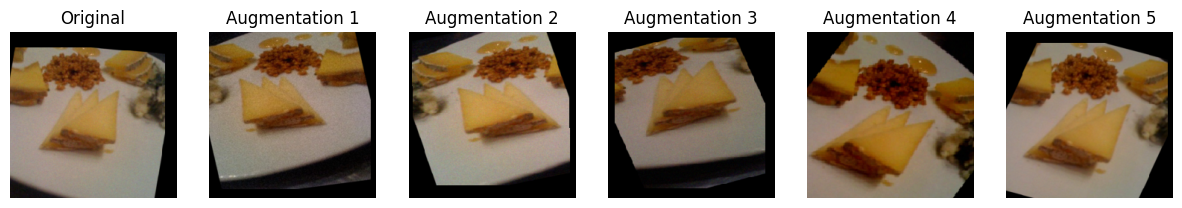

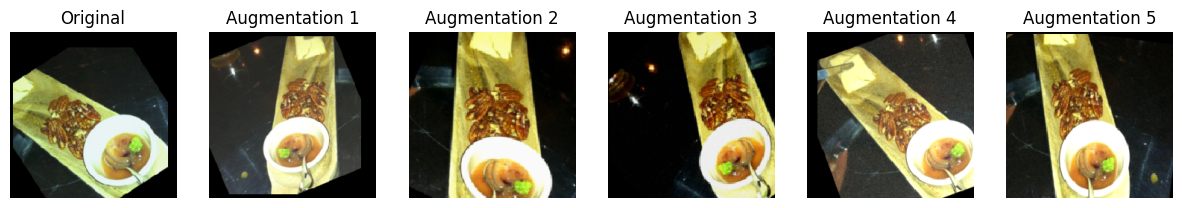

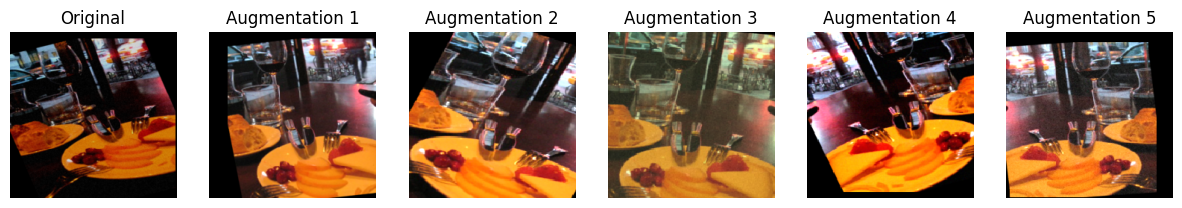

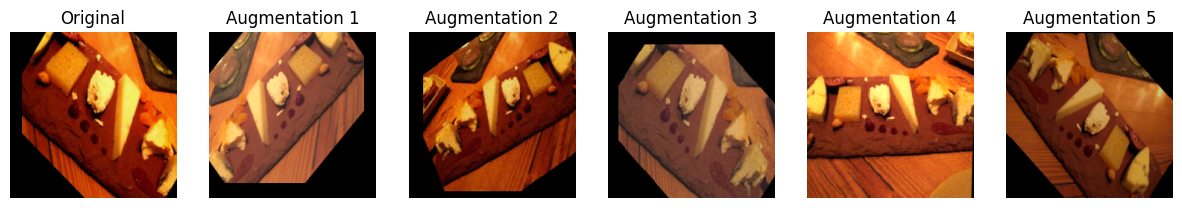

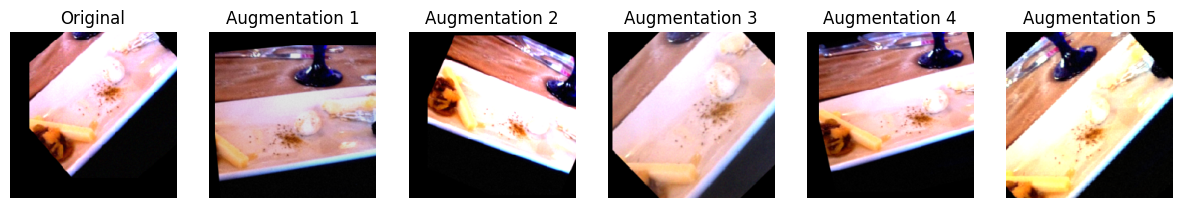

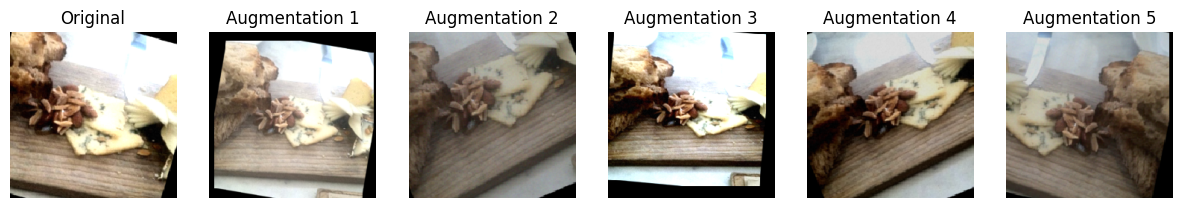

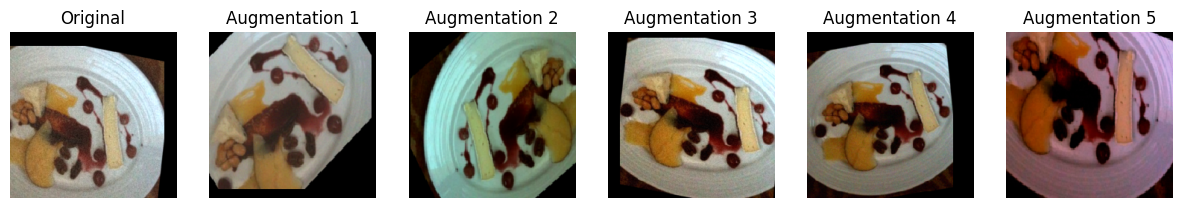

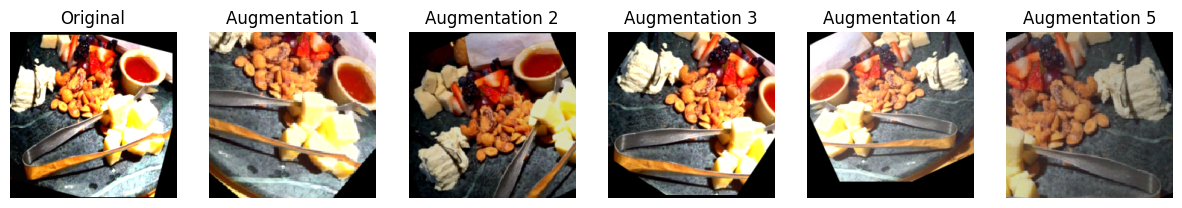

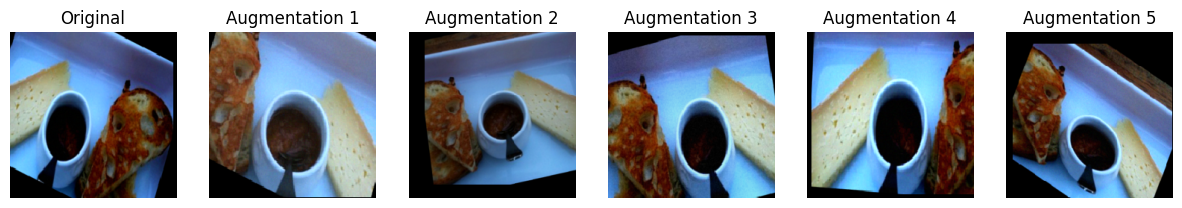

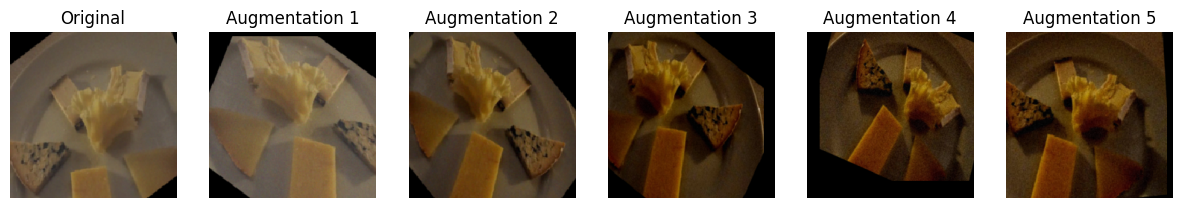

In [18]:
def show_augmentations(dataset, original_idx=0, num_augmentations=5):
    original_img, _ = dataset[original_idx]

    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 3))

    # Display the original image
    axes[0].imshow(np.transpose(original_img.numpy(), (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Original')

    # Display augmentations of the same image
    for i in range(1, num_augmentations + 1):
        augmented_img, _ = dataset[original_idx]
        axes[i].imshow(np.transpose(augmented_img.numpy(), (1, 2, 0)))
        axes[i].axis('off')
        axes[i].set_title(f'Augmentation {i}')

    plt.show()
for i in range(10):
    show_augmentations(train_dataset, original_idx=i, num_augmentations=5)


In [19]:
with open('./data/resample_allergies.txt', 'w') as file:
    for label in allergies:
        file.write(label + '\n')
with open('./data/resample_allergies.txt', 'r') as file:
    allergies = [line.strip() for line in file]
allergies, len(allergies)

(['Mint Allergy',
  'Salicylate Allergy',
  'Cruciferous Allergy',
  'Nut Allergy',
  'Stone Fruit Allergy',
  'Mushroom Allergy',
  'Legume Allergy',
  'Honey Allergy',
  'Histamine Allergy',
  'Fish Allergy',
  'LTP Allergy',
  'Oral Allergy Syndrome',
  'Potato Allergy',
  'Rice Allergy',
  'Soy Allergy',
  'Citrus Allergy',
  'Hypersensitivity',
  'Lactose Intolerance',
  'Sugar Allergy / Intolerance',
  'Nightshade Allergy',
  'Poultry Allergy',
  'Allium Allergy',
  'Milk allergy / Lactose intolerance'],
 23)

In [20]:
class FineTunedDenseNet(nn.Module):
    def __init__(self, num_classes=len(allergies)):
        super(FineTunedDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.conv1x1 = nn.Conv2d(densenet.classifier.in_features, 512, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.conv1x1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def Model():
    return FineTunedDenseNet()

model = Model()
model.to(mps_device)

/Users/mac/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mac/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTunedDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [21]:
def train_loop(train_loader, criterion, optimizer, train_loss, correct_train, total_train):
    for images, targets in tqdm.tqdm(train_loader, desc='Training'):
        images, targets = images.to(mps_device), targets.to(mps_device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        train_loss += loss.item()

        total_batch = (targets.size(0) * targets.size(1))
        total_train += total_batch

        predicted_label = torch.sigmoid(outputs)>=0.5
        target_data = (targets==1.0)
        correct = torch.sum((predicted_label == target_data.to(mps_device)).to(torch.float)).item()
        correct_train += correct
    return train_loss, correct_train, total_train

def evaluate(val_loader, criterion, val_loss, correct_val, total_val):
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(mps_device), targets.to(mps_device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            total_batch = (targets.size(0) * targets.size(1))
            total_val += total_batch

            predicted_label = torch.sigmoid(outputs)>=0.5
            target_data = (targets==1.0)
            correct = torch.sum((predicted_label == target_data.to(mps_device)).to(torch.float)).item()
            correct_val += correct
    return val_loss, correct_val, total_val

In [22]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
def train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    patience = 7
    no_improvement = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        val_loss = 0.0
        correct_val = 0
        total_val = 0

        train_loss, correct_train, total_train = train_loop(train_loader, criterion, optimizer, train_loss, correct_train, total_train)
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = (correct_train / total_train) * 100.0
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        val_loss, correct_val, total_val = evaluate(val_loader, criterion, val_loss, correct_val, total_val)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val) * 100.0
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        lr_scheduler.step(avg_val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f} seconds\n"
            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {avg_train_loss:.4f}\n"
            f"Validation Accuracy: {val_accuracy:.2f}% - Validation Loss: {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [24]:
train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, 60)

Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [1/60] - Time: 6894.97 seconds
Train Accuracy: 95.20% - Train Loss: 0.1285
Validation Accuracy: 92.13% - Validation Loss: 0.1921


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [2/60] - Time: 6850.27 seconds
Train Accuracy: 97.28% - Train Loss: 0.0722
Validation Accuracy: 93.28% - Validation Loss: 0.1673


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [3/60] - Time: 6856.06 seconds
Train Accuracy: 97.81% - Train Loss: 0.0584
Validation Accuracy: 93.85% - Validation Loss: 0.1536


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [4/60] - Time: 7147.80 seconds
Train Accuracy: 98.11% - Train Loss: 0.0505
Validation Accuracy: 94.41% - Validation Loss: 0.1466


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [5/60] - Time: 6910.25 seconds
Train Accuracy: 98.28% - Train Loss: 0.0461
Validation Accuracy: 94.55% - Validation Loss: 0.1460


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [6/60] - Time: 6759.94 seconds
Train Accuracy: 98.42% - Train Loss: 0.0424
Validation Accuracy: 94.70% - Validation Loss: 0.1446


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [7/60] - Time: 6719.80 seconds
Train Accuracy: 98.51% - Train Loss: 0.0396
Validation Accuracy: 95.10% - Validation Loss: 0.1333


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [8/60] - Time: 6786.77 seconds
Train Accuracy: 98.61% - Train Loss: 0.0374
Validation Accuracy: 95.09% - Validation Loss: 0.1332


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [9/60] - Time: 6799.54 seconds
Train Accuracy: 98.68% - Train Loss: 0.0354
Validation Accuracy: 95.14% - Validation Loss: 0.1338


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [10/60] - Time: 6800.44 seconds
Train Accuracy: 98.74% - Train Loss: 0.0339
Validation Accuracy: 95.29% - Validation Loss: 0.1311


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [11/60] - Time: 6820.97 seconds
Train Accuracy: 98.79% - Train Loss: 0.0325
Validation Accuracy: 95.13% - Validation Loss: 0.1366


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [12/60] - Time: 6802.04 seconds
Train Accuracy: 98.83% - Train Loss: 0.0315
Validation Accuracy: 95.38% - Validation Loss: 0.1288


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [13/60] - Time: 6835.11 seconds
Train Accuracy: 98.85% - Train Loss: 0.0306
Validation Accuracy: 95.30% - Validation Loss: 0.1343


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [14/60] - Time: 7493.60 seconds
Train Accuracy: 98.89% - Train Loss: 0.0297
Validation Accuracy: 95.37% - Validation Loss: 0.1317


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [15/60] - Time: 6918.77 seconds
Train Accuracy: 98.93% - Train Loss: 0.0285
Validation Accuracy: 95.49% - Validation Loss: 0.1265


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [16/60] - Time: 6907.23 seconds
Train Accuracy: 98.96% - Train Loss: 0.0280
Validation Accuracy: 95.54% - Validation Loss: 0.1270


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [17/60] - Time: 6739.59 seconds
Train Accuracy: 99.00% - Train Loss: 0.0270
Validation Accuracy: 95.58% - Validation Loss: 0.1274


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [18/60] - Time: 6750.54 seconds
Train Accuracy: 99.01% - Train Loss: 0.0268
Validation Accuracy: 95.56% - Validation Loss: 0.1290


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [19/60] - Time: 6724.41 seconds
Train Accuracy: 99.03% - Train Loss: 0.0262
Validation Accuracy: 95.65% - Validation Loss: 0.1247


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [20/60] - Time: 6754.15 seconds
Train Accuracy: 99.04% - Train Loss: 0.0256
Validation Accuracy: 95.59% - Validation Loss: 0.1235


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [21/60] - Time: 6828.10 seconds
Train Accuracy: 99.07% - Train Loss: 0.0251
Validation Accuracy: 95.60% - Validation Loss: 0.1286


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [22/60] - Time: 6814.99 seconds
Train Accuracy: 99.09% - Train Loss: 0.0245
Validation Accuracy: 95.64% - Validation Loss: 0.1285


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [23/60] - Time: 7108.90 seconds
Train Accuracy: 99.10% - Train Loss: 0.0243
Validation Accuracy: 95.61% - Validation Loss: 0.1271


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [24/60] - Time: 6792.41 seconds
Train Accuracy: 99.11% - Train Loss: 0.0239
Validation Accuracy: 95.66% - Validation Loss: 0.1264


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [25/60] - Time: 6824.59 seconds
Train Accuracy: 99.13% - Train Loss: 0.0235
Validation Accuracy: 95.75% - Validation Loss: 0.1271


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.
Epoch [26/60] - Time: 6837.37 seconds
Train Accuracy: 99.15% - Train Loss: 0.0232
Validation Accuracy: 95.67% - Validation Loss: 0.1308


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

Epoch [27/60] - Time: 6851.92 seconds
Train Accuracy: 99.41% - Train Loss: 0.0158
Validation Accuracy: 96.23% - Validation Loss: 0.1128


Training:   0%|          | 0/4146 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
torch.save(model.state_dict(), './resamplesk_ingredients101/allergies/balanced_data/FineTunedDenseNet_allergies_model.pth')

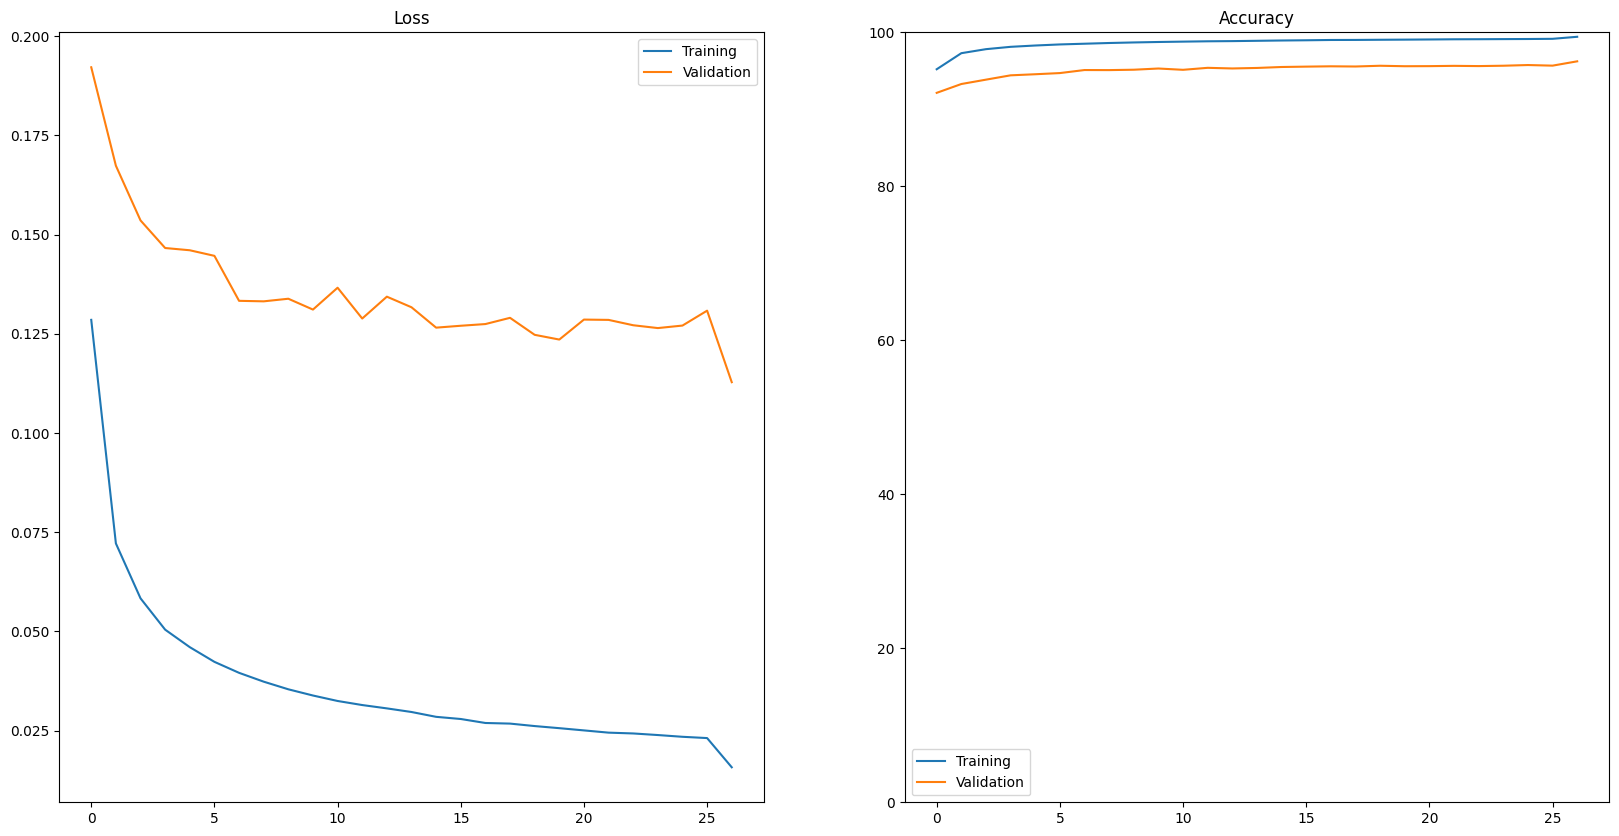

In [26]:
loss_history = {'train_losses': train_losses, 'val_losses': val_losses}
accuracy_history = {'train_accuracies': train_accuracies, 'val_losses': val_accuracies}
with open('./resamplesk_ingredients101/allergies/balanced_data/FineTunedDenseNet_allergies_history.pkl', 'wb') as file:
    pickle.dump(loss_history, file)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(train_losses, label='Training') 
ax1.plot(val_losses, label='Validation')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(train_accuracies, label='Training')
ax2.plot(val_accuracies, label='Validation') 
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 100)
fig.savefig('./resamplesk_ingredients101/allergies/balanced_data/FineTunedDenseNet_allergies_loss_accuracy.png')
plt.show()

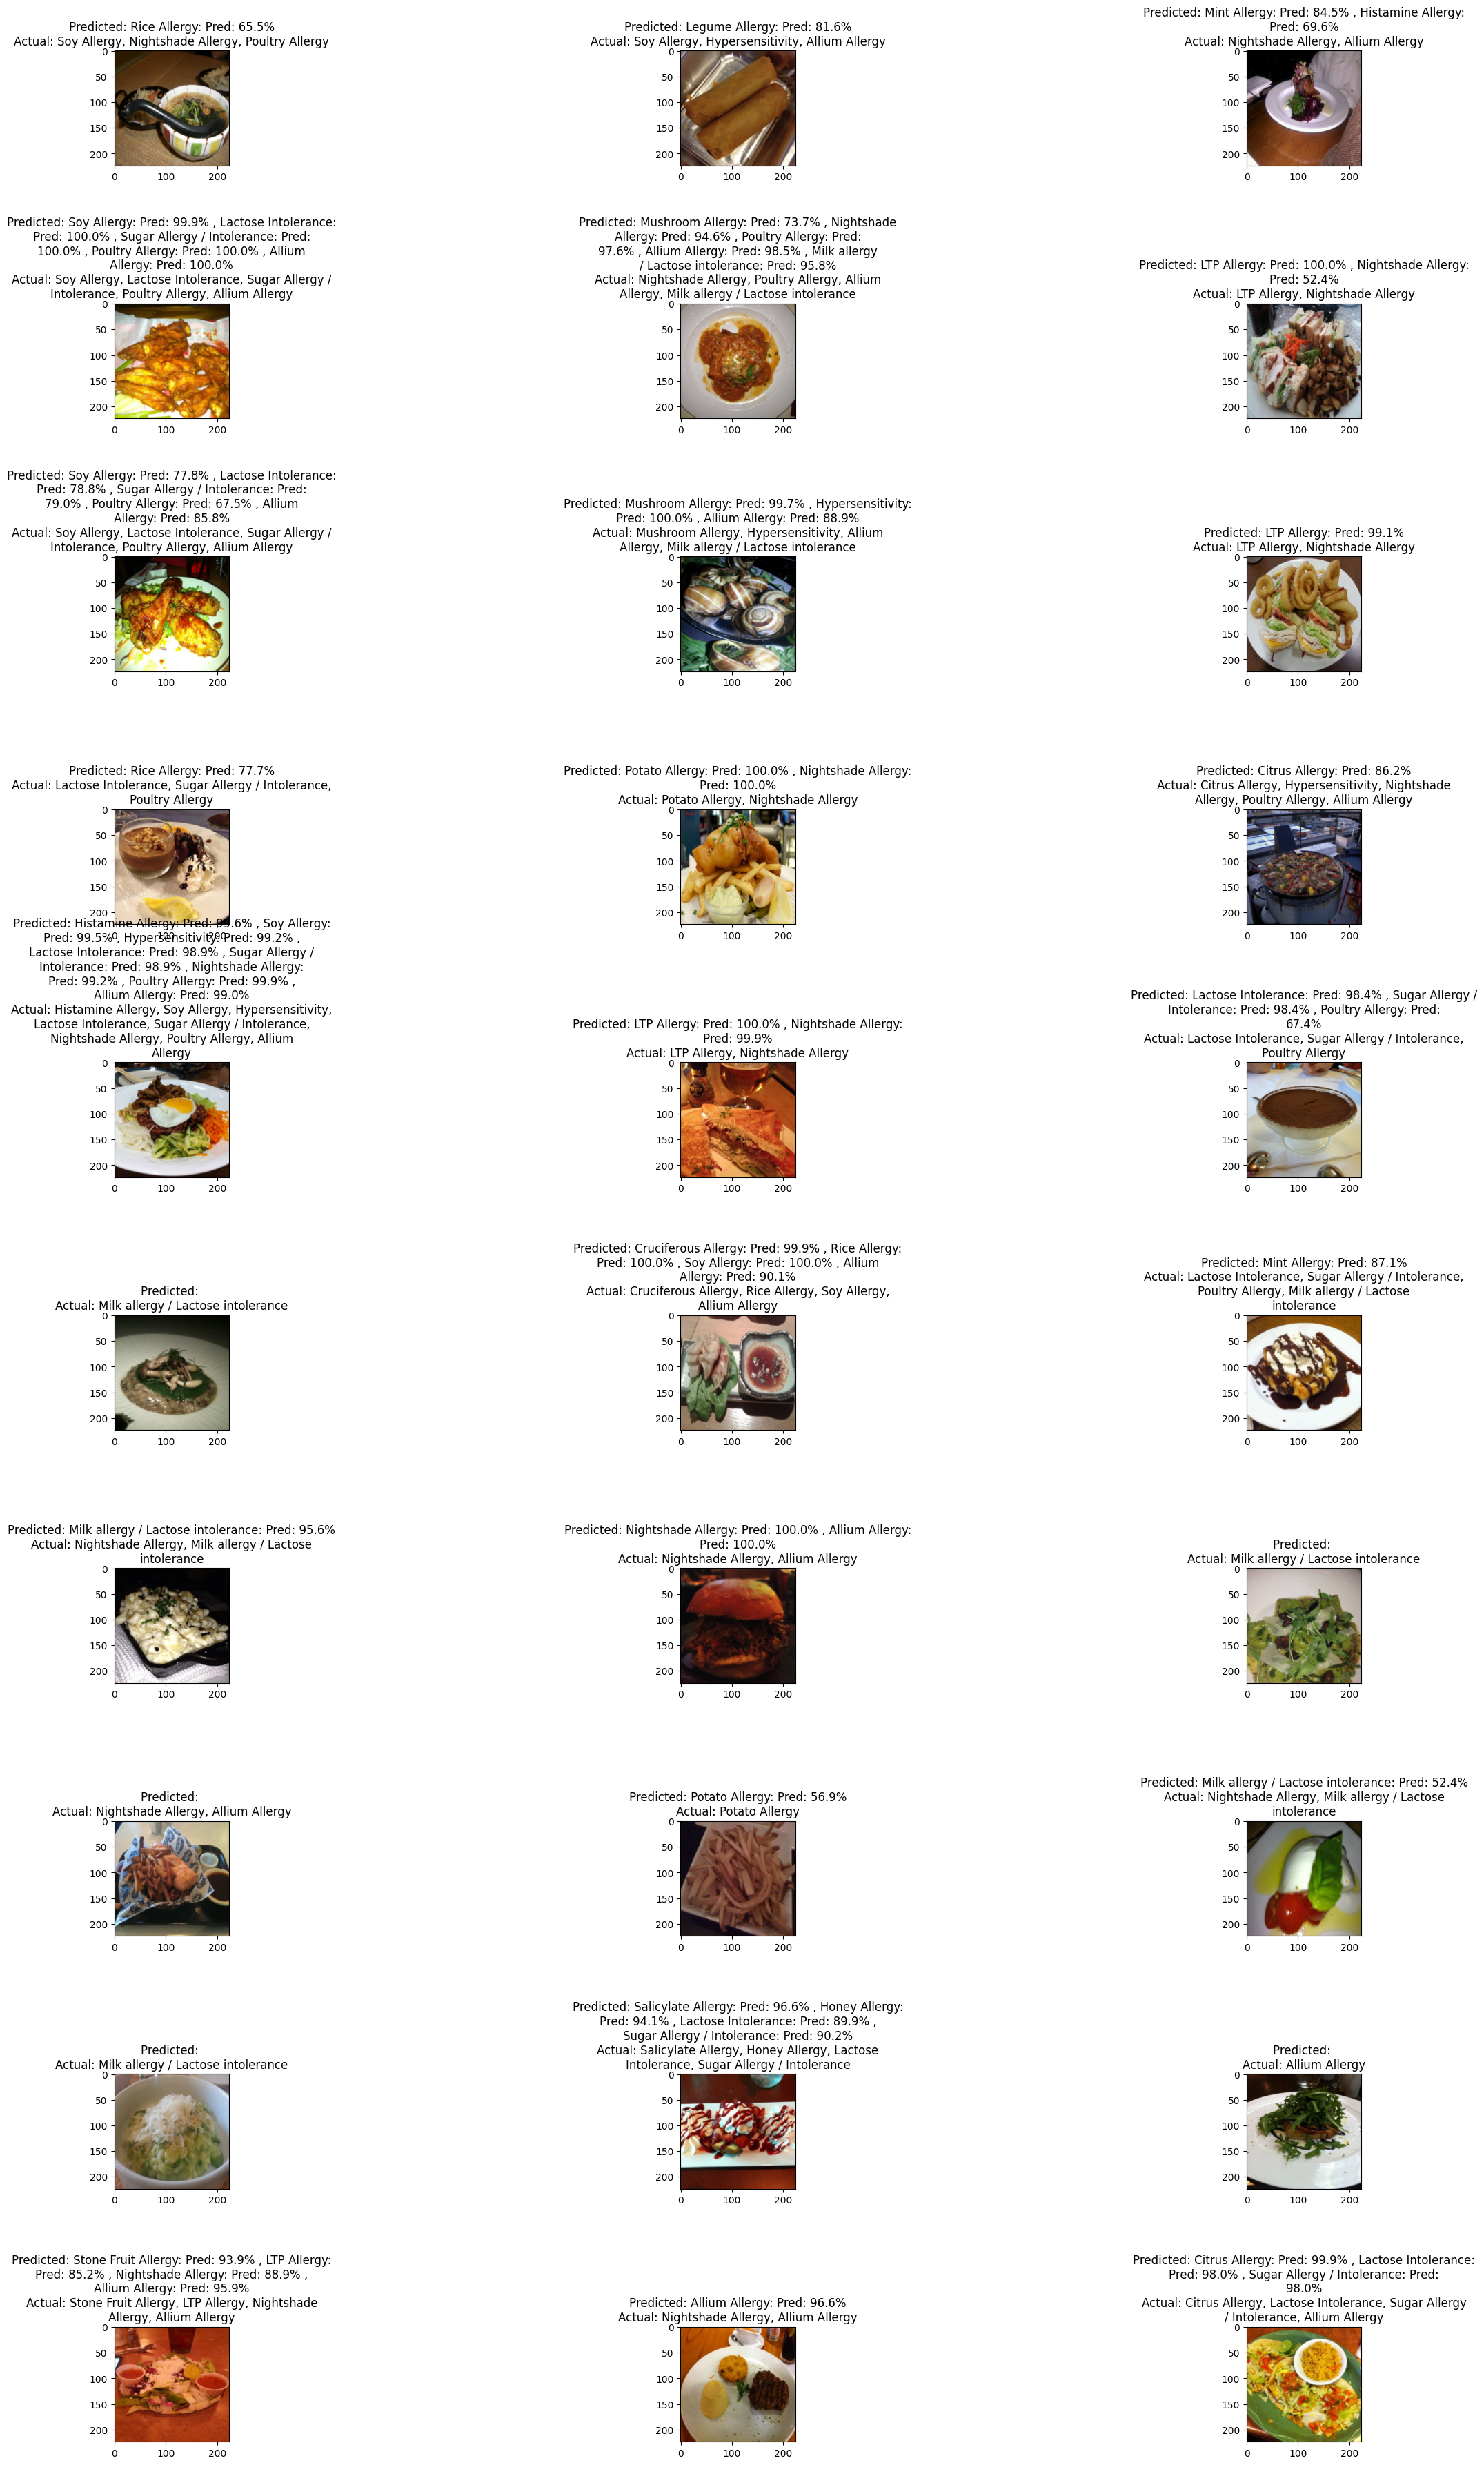

In [31]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.float().to(mps_device), targets.to(mps_device)

outputs = model(inputs)
fig, (m_axs) = plt.subplots(10, 3, figsize=(30, 45), gridspec_kw={'hspace': 1.2})
for i, c_ax in enumerate(m_axs.flatten()):
    pred_title = ', '.join(['{}: Pred: {:2.1f}%\n'.format(allergies[j], 100 * torch.sigmoid(outputs[i, j]).item())
                            for j, v in enumerate(outputs[i])
                            if torch.sigmoid(v) > 0.5])
    wrapped_pred = '\n'.join(textwrap.wrap(pred_title, width=50))

    act_title = ', '.join(['{}'.format(allergies[j]) for j, v in enumerate(targets[i]) if v == 1.0])
    wrapped_act = '\n'.join(textwrap.wrap(act_title, width=50))
    
    img = inputs[i].permute(1, 2, 0).cpu()
    c_ax.imshow(img)
    title = "Predicted: {}\nActual: {}".format(wrapped_pred, wrapped_act)
    c_ax.set_title(title)

In [32]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [34]:
for param in model.parameters():
    param.requires_grad = False
model.eval()

true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc='Testing'):
        images, labels = images.to(mps_device), labels.to(mps_device)
        predictions = model(images)
        
        binary_predictions = (predictions > 0.5).cpu().numpy().astype(int)
        
        predicted_labels.extend(binary_predictions)
        true_labels.extend(labels.cpu().numpy())
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

report = classification_report(true_labels, predicted_labels, target_names=allergies, zero_division=0)
print(report)

f1score_samples = f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
f1score_macro = f1_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
f1score_weighted = f1_score(y_true=true_labels, y_pred=predicted_labels, average='weighted')
recall = recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
prec = precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
hamming = hamming_score(y_true=true_labels, y_pred=predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
hl = hamming_loss(true_labels, predicted_labels)
print("Accuracy: ", accuracy)
print("F1 Samples: ", f1score_samples)
print("F1 Weighted: ", f1score_weighted)
print("Hamming score: ", hamming)
print("Hamming loss: ", hl)

Testing:   0%|          | 0/395 [00:00<?, ?it/s]

                                    precision    recall  f1-score   support

                      Mint Allergy       0.83      0.71      0.77       250
                Salicylate Allergy       0.84      0.82      0.83       250
               Cruciferous Allergy       0.91      0.85      0.88       250
                       Nut Allergy       0.96      0.89      0.92       500
               Stone Fruit Allergy       0.92      0.82      0.87       500
                  Mushroom Allergy       0.87      0.78      0.82       500
                    Legume Allergy       0.91      0.77      0.84       750
                     Honey Allergy       0.89      0.84      0.87      1000
                 Histamine Allergy       0.91      0.86      0.89      1250
                      Fish Allergy       0.91      0.78      0.84      1250
                       LTP Allergy       0.92      0.84      0.88      1250
             Oral Allergy Syndrome       0.89      0.73      0.80      1500
           

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.7516831683168317
F1 Samples:  0.8460541906356117
F1 Weighted:  0.8910136006069431
Hamming score:  0.8307386395782436
Hamming loss:  0.029207059836418425
